<a href="https://colab.research.google.com/github/aryan2107-cloud/100-Day-ML-Challenge-/blob/main/Day22_Support_vector_Machines(SVM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer, make_moons, make_circles
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

## SVM Intuition

**Goal:** Find the hyperplane that maximizes the margin between classes.

- **Support Vectors:** Points closest to the decision boundary
- **Margin:** Distance between support vectors and boundary
- **Maximum Margin:** SVM finds the widest possible margin

In [4]:
cancer = load_breast_cancer()
x = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = cancer.target # 0 = malignant, 1 = benign

print(f"X shape: {x.shape}")
print(f"Y shape: {y.shape}")
print(f"Class distribution: {np.bincount(y)}")

X shape: (569, 30)
Y shape: (569,)
Class distribution: [212 357]


In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print(f"Train shape: {len(x_train)}")
print(f"Test shape: {len(x_test)}")

Train shape: 455
Test shape: 114


Linear SVM


In [25]:
svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(x_train_scaled, y_train)

print(f"Train accuracy: {svm_linear.score(x_train_scaled, y_train)}")
print(f"Test accuracy: {svm_linear.score(x_test_scaled, y_test)}")
print(f"Support Vectors: {len(svm_linear.support_vectors_)}")

Train accuracy: 0.9912087912087912
Test accuracy: 0.9736842105263158
Support Vectors: 32


The C Parameter (Head vs Soft margin)

In [26]:
#C controls the tradeoff between margin width and misclassification
# High c = narrow margin, fewer errors (can overfit)
# Low c = wide margin, more errors allowed (more regularization)

c_values = [0.001, 0.01, 0.1, 1, 10, 100]
results = []

for c in c_values:
  svm = SVC(kernel='linear', C=c, random_state=42)
  svm.fit(x_train_scaled, y_train)
  results.append({
      'C': c,
      'Train Accuracy': svm.score(x_train_scaled, y_train),
      'Test Accuracy': svm.score(x_test, y_test),
      'Support vectors': len(svm.support_vectors_)
  })

results_df = pd.DataFrame(results)
print("the effect of c parameter: ")
print(f"{results_df.to_string(index=False)}")

the effect of c parameter: 
      C  Train Accuracy  Test Accuracy  Support vectors
  0.001        0.940659       0.368421              212
  0.010        0.978022       0.368421               99
  0.100        0.984615       0.368421               51
  1.000        0.991209       0.368421               32
 10.000        0.991209       0.368421               26
100.000        0.995604       0.368421               26


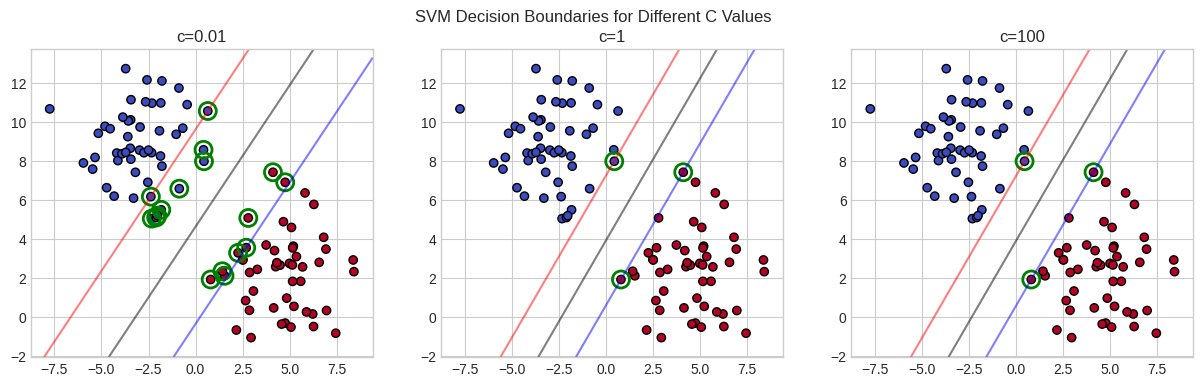

In [27]:
# visualizing the c effect
x_2d, y_2d = make_blobs(n_samples=100, centers=2, random_state=42, cluster_std=2)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, c in zip(axes, [0.01, 1, 100]):
  svm = SVC(kernel='linear', C=c)
  svm.fit(x_2d, y_2d)

  #Decision boundary
  xx, yy = np.meshgrid(np.linspace(x_2d[:, 0].min()-1, x_2d[:, 0].max()+1, 200),
                       np.linspace(x_2d[:, 1].min()-1, x_2d[:, 1].max()+1, 200))
  z = svm.decision_function(np.c_[xx.ravel(),
                                  yy.ravel()]).reshape(xx.shape)
  ax.contour(xx, yy, z, levels=[-1, 0, 1], alpha=0.5, colors=['red', 'black', 'blue'])
  ax.scatter(x_2d[:, 0], x_2d[:, 1], c=y_2d, cmap='coolwarm', edgecolor='black')
  ax.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], s=150, facecolor='none', edgecolors='green', linewidths=2)
  ax.set_title(f"c={c}")

plt.suptitle("SVM Decision Boundaries for Different C Values")
plt.show()

##Kernel Trick

**Problem:** Data not linearly separable

**Solution:** Map to higher dimensions where it IS separable

**Kernel Trick:** Compute dot products in high-D space without actually transforming

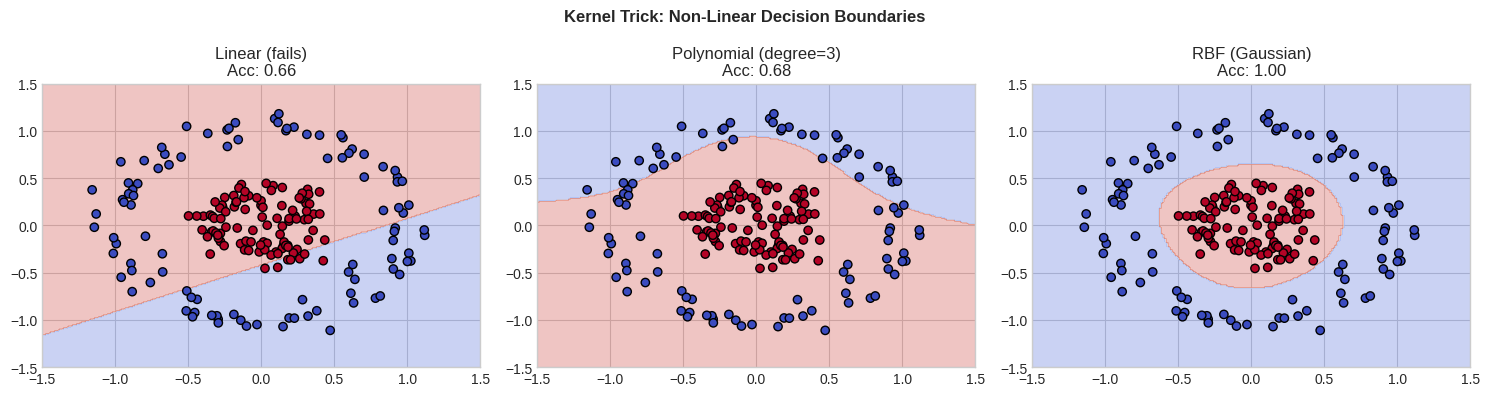

In [28]:
# Demo: Non-linear data
X_circles, y_circles = make_circles(n_samples=200, noise=0.1, factor=0.3, random_state=42)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

kernels = ['linear', 'poly', 'rbf']
titles = ['Linear (fails)', 'Polynomial (degree=3)', 'RBF (Gaussian)']

for ax, kernel, title in zip(axes, kernels, titles):
    if kernel == 'poly':
        svm = SVC(kernel=kernel, degree=3)
    else:
        svm = SVC(kernel=kernel)
    svm.fit(X_circles, y_circles)

    # Decision boundary
    xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 200), np.linspace(-1.5, 1.5, 200))
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    ax.scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap='coolwarm', edgecolor='black')
    ax.set_title(f'{title}\nAcc: {svm.score(X_circles, y_circles):.2f}')

plt.suptitle('Kernel Trick: Non-Linear Decision Boundaries', fontweight='bold')
plt.tight_layout()
plt.show()

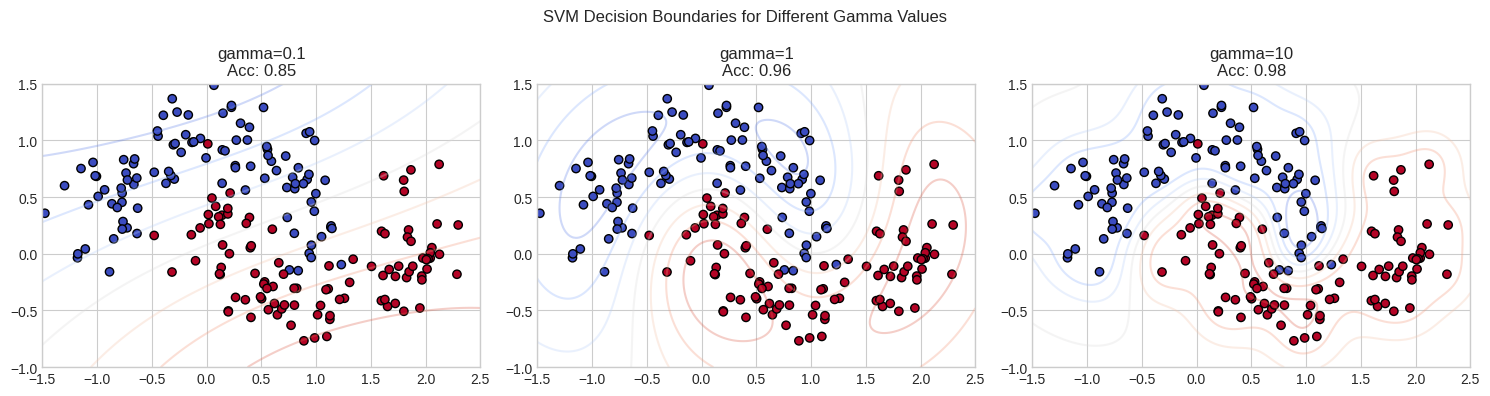

In [29]:
#Gamma controls the 'reach' of each training example
# High Gamma = points have local influence (can overfit)
# Low gamma = points have far reach (another boundary)

x_moons, y_moons = make_moons(n_samples=200, noise=0.2, random_state=42)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

gammas = [0.1, 1, 10]

for ax, gamma in zip(axes, gammas):
  svm = SVC(kernel='rbf', gamma=gamma, C=1)
  svm.fit(x_moons, y_moons)

  xx, yy = np.meshgrid(np.linspace(-1.5, 2.5, 200),
                       np.linspace(-1, 1.5, 200))
  z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

  ax.contour(xx, yy, z, alpha=0.3, cmap='coolwarm')
  ax.scatter(x_moons[:, 0], x_moons[:, 1], c=y_moons, cmap='coolwarm', edgecolor='black')
  ax.set_title(f"gamma={gamma}\nAcc: {svm.score(x_moons, y_moons):.2f}")

plt.suptitle("SVM Decision Boundaries for Different Gamma Values")
plt.tight_layout()
plt.show()

Different kernels on the dataset

In [30]:
#Comapre models
kernels = {
    'Linear': SVC(kernel='linear', random_state=42),
    'RBF': SVC(kernel='rbf', random_state=42),
    'Polynomial (d=3)': SVC(kernel='poly', degree=3, random_state=42),
    'sigmoid': SVC(kernel='sigmoid', random_state=42)
}

print("Kernel comparison")
print(f"{'Kernel':<18} {'Train Acc':<12} {'Test Acc':<12} {'CV Acc':<12}")

for name, model in kernels.items():
  model.fit(x_train_scaled, y_train)
  cv_scores = cross_val_score(model, x_train_scaled, y_train, cv=5)
  print(f"{name:<18} {model.score(x_train_scaled, y_train):<12.4f}"
        f"{model.score(x_test_scaled, y_test):<12.4f} {cv_scores.mean():<12.4f}")

Kernel comparison
Kernel             Train Acc    Test Acc     CV Acc      
Linear             0.9912      0.9737       0.9670      
RBF                0.9824      0.9825       0.9714      
Polynomial (d=3)   0.9165      0.9123       0.8967      
sigmoid            0.9560      0.9298       0.9692      


Hyperparameter Tuning

In [31]:
#Grid search for RBF Kernel
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

grid_search = GridSearchCV(SVC(kernel='rbf', random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(x_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")
print(f"Test accuracy: {grid_search.score(x_test_scaled, y_test)}")

Best parameters: {'C': 10, 'gamma': 0.01}
Best cross-validation score: 0.9802197802197803
Test accuracy: 0.9824561403508771


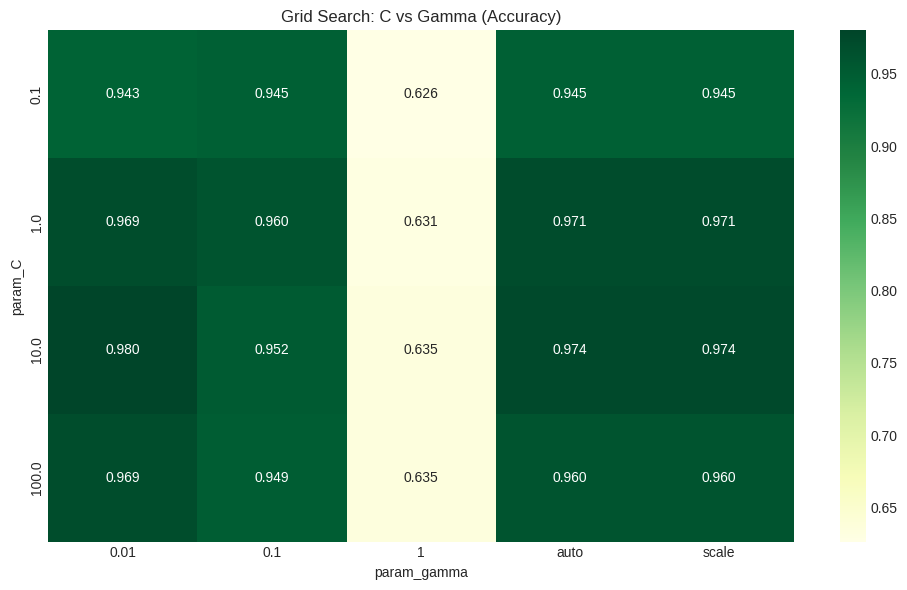

In [32]:
results = pd.DataFrame(grid_search.cv_results_)
pivot = results.pivot_table(index='param_C', columns='param_gamma', values='mean_test_score')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlGn')
plt.title('Grid Search: C vs Gamma (Accuracy)')
plt.tight_layout()
plt.show()

SVM For regression

In [36]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error, r2_score

housing = fetch_california_housing()
x_reg = housing.data[:2000]
y_reg = housing.target[:2000]

x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x_reg, y_reg, test_size=0.2, random_state=42)

scaler_reg = StandardScaler()
x_train_reg_scaled = scaler_reg.fit_transform(x_train_reg)
x_test_reg_scaled = scaler_reg.transform(x_test_reg)

#SVR
svr = SVR(kernel='rbf', C=1, epsilon=0.1)
svr.fit(x_train_reg_scaled, y_train_reg)

y_pred_reg = svr.predict(x_test_reg_scaled)

print(f"MSE: {mean_squared_error(y_test_reg, y_pred_reg)}")
print(f"R2 Score: {r2_score(y_test_reg, y_pred_reg)}")

MSE: 0.1515507249454057
R2 Score: 0.8340969783387706


##Final Evaluation

In [37]:
#%%
# Best model evaluation
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(x_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=cancer.target_names))

Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



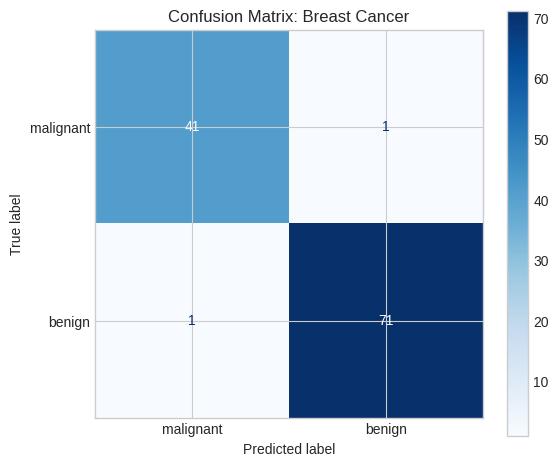

In [38]:
#%%
# Confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                         display_labels=cancer.target_names,
                                         cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix: Breast Cancer')
plt.tight_layout()
plt.show()

In [40]:

# Compare with other models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM (Linear)': SVC(kernel='linear', random_state=42),
    'SVM (RBF, tuned)': best_svm
}

print("\nModel Comparison:")
print(f"{'Model':<25} {'Test Accuracy':<15}")
print("-" * 40)

for name, model in models.items():
    if name != 'SVM (RBF, tuned)':
        model.fit(x_train_scaled, y_train)
    acc = model.score(x_test_scaled, y_test)
    print(f"{name:<25} {acc:<15.4f}")


Model Comparison:
Model                     Test Accuracy  
----------------------------------------
Logistic Regression       0.9825         
Random Forest             0.9561         
SVM (Linear)              0.9737         
SVM (RBF, tuned)          0.9825         



## Summary

### SVM Key Concepts

| Concept | Description |
|---------|-------------|
| Maximum Margin | Find widest gap between classes |
| Support Vectors | Points on/near the margin |
| Kernel Trick | Non-linear boundaries without explicit transform |

### Key Parameters

| Parameter | Effect |
|-----------|--------|
| C | Regularization (low=wide margin, high=narrow) |
| gamma | RBF reach (low=smooth, high=wiggly) |
| kernel | linear, rbf, poly, sigmoid |

### When to Use SVM

**Good for:**
- High-dimensional data (text, images)
- Clear margin of separation
- Small to medium datasets

**Not ideal for:**
- Very large datasets (slow)
- Noisy data with overlapping classes
- When probability estimates needed (use `probability=True`, but slower)

### Important
- **Always scale features!**
- Start with RBF kernel
- Tune C and gamma together